In [3]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import seaborn as sns
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 

2023-03-21 16:51:56.914291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow  2.11.0
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


In [4]:
def visualize_matrix(matrix, cmap='viridis'):
    """
    matrix: Matrix to be visualized with a color mapping
    cmap: type of mapping
    ---
    It displays a matrix represented with a color scheme
    """
    D = matrix.shape[0]
    #plt.imshow(matrix, cmap=cmap, extent=[0, D, 0, D], interpolation='nearest')
    #plt.xticks(np.arange(D) + 0.5, np.arange(D))
    #plt.yticks(np.arange(D) + 0.5, np.arange(D))
    #plt.colorbar()
    #plt.show()
    min = np.min(matrix)
    max = np.max(matrix)
    center = (min+max)/2
    sns.heatmap(matrix, annot=True, cmap='vlag', vmax=max, vmin=min, center=center, linewidth=.5)


In [5]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.boston_housing.load_data()
Y_train = np.atleast_2d(Y_train).T
Y_test = np.atleast_2d(Y_test).T
Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
Y_train = (Y_train - Y_train_mean) / Y_train_std
Y_test = (Y_test - Y_train_mean) / Y_train_std
D = X_train.shape[1]
#X_train = X_train[:,0:D]

<AxesSubplot: >

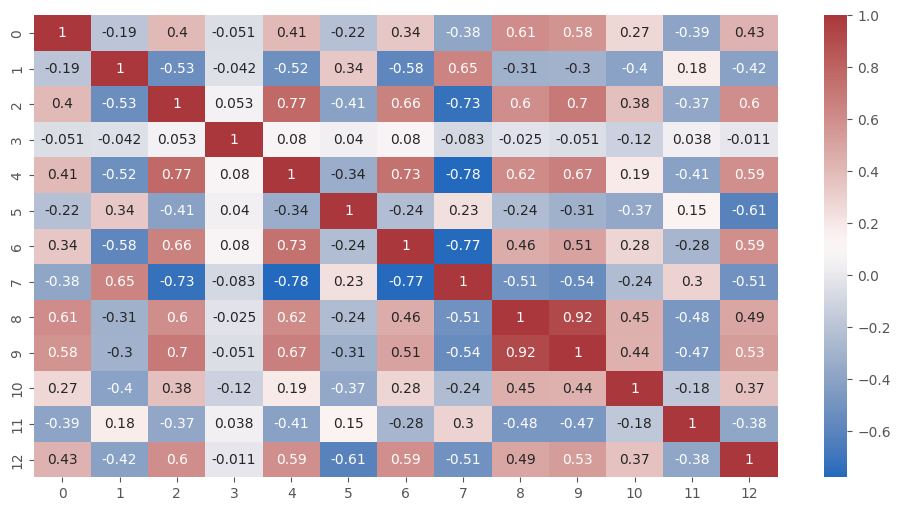

In [6]:
index_values = ['%d'%(i) for i in range(X_train.shape[0])]
column_values = ['%d'%(i) for i in range(X_train.shape[1])]
df = pd.DataFrame(data = X_train, 
                  index = index_values, 
                  columns = column_values)
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='vlag')

In [7]:
def get_lower_triangular_diag(diag):
    Lambda_inv = tf.linalg.diag(diag)
    Lambda = tf.linalg.inv(Lambda_inv)
    L = tf.linalg.cholesky(Lambda)
    return L

lengthscales = tf.constant([D**0.5]*13, dtype=tf.float32)
Lambda_L = get_lower_triangular_diag(lengthscales)
Lambda_L
#tf.linalg.inv(Lambda_L)

2023-03-21 16:52:38.257154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(13, 13), dtype=float32, numpy=
array([[0.5266404, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.5266404, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.5266404, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.5266404, 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.5266404, 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.5266404,
        0.       , 0.       , 0.    

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,FillTriangular,Normal,True,"(13, 13)",float64,"[[0.52664, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Initial value of Lambda:  tf.Tensor(
[[0.2773501 0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.2773501 0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.2773501 0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.2773501 0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.2773501 0.        0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.2773501 0.
  0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.2773501
  0.

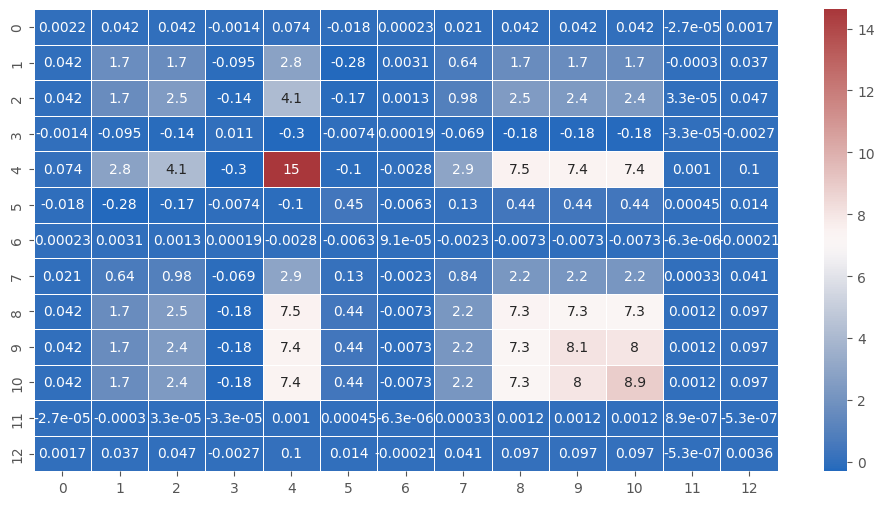

In [8]:
#Lambda = tf.constant([[1/4, 0],[0, 1/4]], dtype=tf.float64)#(1/4)*tf.eye(2, dtype=tf.float64)
D = 13
triangular_size = gpflow.utilities.bijectors.triangular_size(D)
#l = tf.zeros([triangular_size], dtype=tf.float64)
#l = tf.constant([0.5,0.,0.5], dtype=tf.float64)
#Lambda_L = tfp.math.fill_triangular(l)
lengthscales = tf.constant([D**0.5]*D, dtype=tf.float64)
Lambda_L = get_lower_triangular_diag(lengthscales)
LRBF = LambdaRBF(Lambda_L, 1.0)
LRBF.Lambda_L.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
LRBF.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
model_LRBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LRBF
,
)
gpflow.utilities.print_summary(model_LRBF, fmt="notebook")
print('Intial value of kernel variance: ', LRBF.variance)
print('Initial value of Lambda: ', tf.linalg.matmul(LRBF.Lambda_L, tf.transpose(LRBF.Lambda_L)))
print('Initial LML: ',model_LRBF.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_LRBF.training_loss, model_LRBF.trainable_variables)
Lambda_full = tf.linalg.matmul(LRBF.Lambda_L, tf.transpose(LRBF.Lambda_L))
print('-------------------------------')
print('Optimal value of kernel variance: ', LRBF.variance)
print('Final value of Lambda: ', Lambda_full)
print('Final LML: ',model_LRBF.log_marginal_likelihood())
visualize_matrix(Lambda_full)

In [9]:
y_pred_train, _ = model_LRBF.predict_f(X_train)
train_rmse_stan = tf.sqrt(tf.reduce_mean((Y_train - y_pred_train)**2)).numpy()
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
y_pred_test, _ = model_LRBF.predict_f(X_test)
test_rmse_stan = tf.sqrt(tf.reduce_mean((Y_test - y_pred_test)**2)).numpy()
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.121
Test RMSE (Standardised): 0.501


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,Normal,True,"(13,)",float64,"[3.60555, 3.60555, 3.60555..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Intial value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[13], fn="softplus", numpy=
array([3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.60555128,
       3.60555128, 3.60555128, 3.60555128, 3.60555128, 3.60555128,
       3.60555128, 3.60555128, 3.60555128])>
Initial LML:  tf.Tensor(-596.9581932967583, shape=(), dtype=float64)
-------------------------------
Optimal value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7690938309513308>
Optimal value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[13], fn="softplus", numpy=
array([3.84702933, 1.00032045, 1.00033834, 2.04538162, 0.31640921,
       1.94130894, 6.37579123, 2.23841261, 1.00070111, 0.99877259,
       1.00036933, 6.45505217, 5.09841146])>
Final LML:  tf.Tensor(-483.3437548093102, shape=(), dtype=float64)


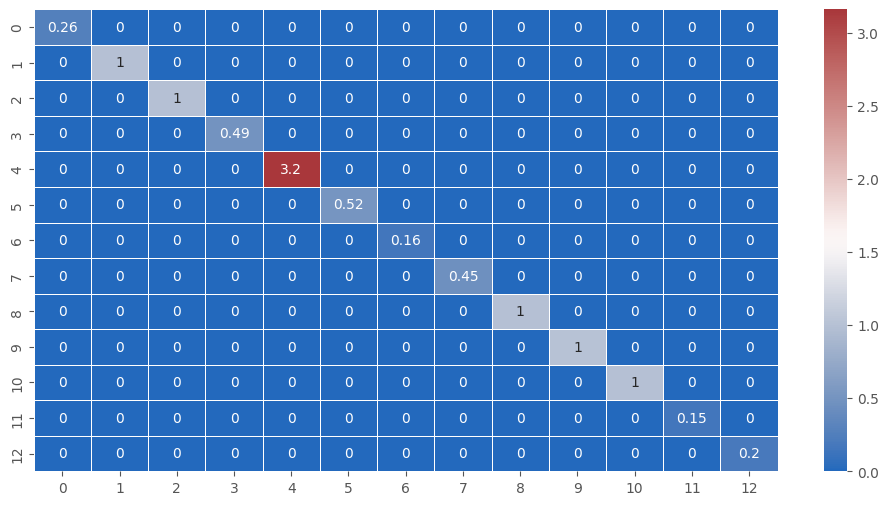

In [10]:
k = gpflow.kernels.SquaredExponential(variance=1, lengthscales=(D**0.5)*np.ones(D))
k.lengthscales.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), 
                                                   scale=gpflow.utilities.to_default_float(1.))
k.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), 
                                               scale=gpflow.utilities.to_default_float(1.))
model_RBF = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=k,
)
gpflow.utilities.print_summary(model_RBF, fmt="notebook")
print('Intial value of kernel variance: ', k.variance)
print('Intial value of kernel lengthsclaes: ', k.lengthscales)
print('Initial LML: ',model_RBF.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model_RBF.training_loss, model_RBF.trainable_variables)
Lambda_diag = tf.linalg.inv(tf.linalg.diag(k.lengthscales))
print('-------------------------------')
print('Optimal value of kernel variance: ', k.variance)
print('Optimal value of kernel lengthsclaes: ', k.lengthscales)
print('Final LML: ', model_RBF.log_marginal_likelihood())
visualize_matrix(Lambda_diag)

In [11]:
y_pred_train, _ = model_RBF.predict_f(X_train)
train_rmse_stan = tf.sqrt(tf.reduce_mean((Y_train - y_pred_train)**2)).numpy()
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
y_pred_test, _ = model_RBF.predict_f(X_test)
test_rmse_stan = tf.sqrt(tf.reduce_mean((Y_test - y_pred_test)**2)).numpy()
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

Train RMSE (Standardised): 0.044
Test RMSE (Standardised): 0.762
